## Imports of utility functions we will be using
below we import the work for our residual network and deep hybrid scatter network. All the real 'heavy lifting' for this project was done in the resnet and ScatterTransform scripts. For a more detailed look at what's going on under the hood go give the scripts a peak.

In [1]:
import sys
import os
sys.path.append('/home/ubuntu/feature_viz/resnet')
sys.path.append('/home/ubuntu/feature_viz/ScatteringTransform/src/model')
from flags import define_flags as scatternet_define_flags
from train_mnist import train_model as scatternet_train
from res_features import train as resnet_train
from visualize import visualize_features
import sklearn
import tensorflow as tf

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


# FEATURE EXTRACTION WITH RESIDUAL NETWORK AND FINE TUNING
## Resnet 50 pretrained from the Kth layer and higher
Below we generate two different pretrained residual networks. In both cases we generate a 50 layer residual network. The network variables are initialized with the values from a pretrained imagenet model. The difference between these two models is that one freezes weights before layer k while the other network leaves all variables as trainable. The inspiration behind this type of pretraining is because the initial layers of a CNN are learning features which are generally task invariant. As a result of this we make the assumption that the layers before K are "good enough" and our training should be spent on tuning the layers >= K.

In the case of both resnets we stack an additional 3 fully connected layers on top of the flattened previously generated features. The first 2 layers use recified linear units as activation functions followed by a final layer which uses a softmax. All 3 of these layers initialize weights with a uniform Xavier initializer. More information on the motivation behind Xavier initializers can be found [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

The purpose of the final 3 stacked fully connected layers is to generate logits for classification. These layers can be thought of as replacements to the final fully connected layers generating logits for the 1000 imagenet classes. In addition to a classification mismatch between imagenet and MNIST we do not take variables from these layers because they are far more task dependent.

In [2]:
resnet_classifier_4 = resnet_train(freeze_before_k=4) # all blocks before block k are frozen for training
tf.reset_default_graph() # clear graph for classifier_0
resnet_classifier_0 = resnet_train(freeze_before_k=0)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/resnet_v1_50.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block4/mnist-800
iter 800 train accuracy: 0.5625
Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/resnet_v1_50.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/feature_viz/resnet/mnist_ckpt_block0/mnist-800
iter 800 train accuracy: 0.9765625


# FEATURE EXTRACTION WITH SCATTER NETWORK
## Scatternet Training and Testing on MNIST
The work for scatternet was mostly based off the work done by [tdeboissiere](https://github.com/tdeboissiere) found [here](https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/ScatteringTransform). This scatter network is actually a bit different than the scatter network found in Brunna & Mallat's work. What we analyze here is  a deep hybrid scatter network. We use scatter transforms similar to those found in [Brunna & Mallat's work](https://arxiv.org/abs/1203.1513) followed by a few convolutional layers and fully connected layers. A detailed explanation of how this works can be found in Oyallon's [Deep Hybrid Networks paper](https://arxiv.org/abs/1703.08961).

In [3]:
scatternet_define_flags() 
scatternet_classifier = scatternet_train()  # no pretrained weights for the hybrid scatter net so we do not need to specify a k


Setting up TF session:

Configuring directories:
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/logs
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/models
[Deleting] /home/ubuntu/feature_viz/ScatteringTransform/src/figures
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/logs
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/models
[Creating] /home/ubuntu/feature_viz/ScatteringTransform/src/figures
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/train-images-idx3-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/train-labels-idx1-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/t10k-images-idx3-ubyte.gz
Extracting /home/ubuntu/feature_viz/ScatteringTransform/src/data/raw/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Summary name HCNN/CONV2D/conv2d/w:0 is illegal; using HCNN/CONV2D/conv2d/w_0 instead.
INFO:tensorflow:Summary name HCNN/CONV2D/conv2d/b:0 is illegal; us

Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 0: - train loss: 2.35 val loss: 2.47 - train acc: 0.10 val acc: 0.09:   0%|          | 0/30 [00:03<?, ?it/s]
Epoch 0: - train loss: 2.35 val loss: 2.47 - train acc: 0.10 val acc: 0.09:   3%|▎         | 1/30 [00:03<01:42,  3.54s/it]
Epoch 0: - train loss: 2.38 val loss: 2.39 - train acc: 0.05 val acc: 0.12:   3%|▎         | 1/30 [00:03<01:51,  3.84s/it]
Epoch 0: - train loss: 2.40 val loss: 2.36 - train acc: 0.12 val acc: 0.12:   3%|▎         | 1/30 [00:04<01:59,  4.13s/it]
Epoch 0: - train loss: 2.40 val loss: 2.36 - train acc: 0.12 val acc: 0.12:  10%|█         | 3/30 [00:04<00:37,  1.38s/it]
Epoch 0: - train loss: 2.33 val loss: 2.37 - train acc: 0.15 val acc: 0.13:  10%|█         | 3/30 [00:04<00:39,  1.48s/it]
Epoch 0: - train loss: 2.36 val loss: 2.27 - train acc: 0.12 val acc: 0.14:  10%|█         | 3/30 [00:04<00:42,  1.58s/it]
Epoch 0: - train loss: 2.36 val loss: 2.27 - train acc: 0.12 val acc: 0.14:  17%|█▋        | 5/30 [

Epoch 1: - train loss: 2.02 val loss: 2.03 - train acc: 0.40 val acc: 0.38:  40%|████      | 12/30 [00:04<00:06,  2.89it/s]
Epoch 1: - train loss: 2.02 val loss: 2.03 - train acc: 0.40 val acc: 0.38:  47%|████▋     | 14/30 [00:04<00:04,  3.37it/s]
Epoch 1: - train loss: 1.99 val loss: 1.97 - train acc: 0.40 val acc: 0.45:  47%|████▋     | 14/30 [00:04<00:05,  3.13it/s]
Epoch 1: - train loss: 1.99 val loss: 1.97 - train acc: 0.38 val acc: 0.37:  47%|████▋     | 14/30 [00:04<00:05,  2.94it/s]
Epoch 1: - train loss: 1.99 val loss: 1.97 - train acc: 0.38 val acc: 0.37:  53%|█████▎    | 16/30 [00:04<00:04,  3.36it/s]
Epoch 1: - train loss: 2.00 val loss: 2.01 - train acc: 0.38 val acc: 0.36:  53%|█████▎    | 16/30 [00:05<00:04,  3.16it/s]
Epoch 1: - train loss: 1.98 val loss: 1.93 - train acc: 0.45 val acc: 0.48:  53%|█████▎    | 16/30 [00:05<00:04,  2.99it/s]
Epoch 1: - train loss: 1.98 val loss: 1.93 - train acc: 0.45 val acc: 0.48:  60%|██████    | 18/30 [00:05<00:03,  3.36it/s]
Epoch 1:

Epoch 2: - train loss: 1.70 val loss: 1.57 - train acc: 0.61 val acc: 0.65:  87%|████████▋ | 26/30 [00:08<00:01,  3.22it/s]
Epoch 2: - train loss: 1.71 val loss: 1.74 - train acc: 0.57 val acc: 0.62:  87%|████████▋ | 26/30 [00:08<00:01,  3.11it/s]
Epoch 2: - train loss: 1.71 val loss: 1.74 - train acc: 0.57 val acc: 0.62:  93%|█████████▎| 28/30 [00:08<00:00,  3.35it/s]
Epoch 2: - train loss: 1.64 val loss: 1.66 - train acc: 0.69 val acc: 0.68:  93%|█████████▎| 28/30 [00:08<00:00,  3.23it/s]
Epoch 2: - train loss: 1.65 val loss: 1.64 - train acc: 0.64 val acc: 0.69:  93%|█████████▎| 28/30 [00:08<00:00,  3.12it/s]
Epoch 2: - train loss: 1.65 val loss: 1.64 - train acc: 0.64 val acc: 0.69: 100%|██████████| 30/30 [00:08<00:00,  3.34it/s]
Epoch 3:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 3: - train loss: 1.61 val loss: 1.62 - train acc: 0.69 val acc: 0.64:   0%|          | 0/30 [00:00<?, ?it/s]
Epoch 3: - train loss: 1.58 val loss: 1.58 - train acc: 0.66 val acc: 0.67:   0%|          | 

Epoch 4: - train loss: 1.36 val loss: 1.30 - train acc: 0.78 val acc: 0.80:  27%|██▋       | 8/30 [00:02<00:08,  2.68it/s]
Epoch 4: - train loss: 1.36 val loss: 1.30 - train acc: 0.78 val acc: 0.80:  33%|███▎      | 10/30 [00:02<00:05,  3.35it/s]
Epoch 4: - train loss: 1.38 val loss: 1.27 - train acc: 0.73 val acc: 0.84:  33%|███▎      | 10/30 [00:03<00:06,  3.03it/s]
Epoch 4: - train loss: 1.37 val loss: 1.34 - train acc: 0.77 val acc: 0.77:  33%|███▎      | 10/30 [00:03<00:07,  2.78it/s]
Epoch 4: - train loss: 1.37 val loss: 1.34 - train acc: 0.77 val acc: 0.77:  40%|████      | 12/30 [00:03<00:05,  3.34it/s]
Epoch 4: - train loss: 1.33 val loss: 1.42 - train acc: 0.73 val acc: 0.76:  40%|████      | 12/30 [00:03<00:05,  3.09it/s]
Epoch 4: - train loss: 1.24 val loss: 1.32 - train acc: 0.82 val acc: 0.74:  40%|████      | 12/30 [00:04<00:06,  2.86it/s]
Epoch 4: - train loss: 1.24 val loss: 1.32 - train acc: 0.82 val acc: 0.74:  47%|████▋     | 14/30 [00:04<00:04,  3.33it/s]
Epoch 4: 

Epoch 5: - train loss: 1.07 val loss: 1.10 - train acc: 0.84 val acc: 0.82:  73%|███████▎  | 22/30 [00:06<00:02,  3.20it/s]
Epoch 5: - train loss: 1.05 val loss: 1.14 - train acc: 0.84 val acc: 0.80:  73%|███████▎  | 22/30 [00:07<00:02,  3.07it/s]
Epoch 5: - train loss: 1.05 val loss: 1.14 - train acc: 0.84 val acc: 0.80:  80%|████████  | 24/30 [00:07<00:01,  3.35it/s]
Epoch 5: - train loss: 1.03 val loss: 1.04 - train acc: 0.83 val acc: 0.83:  80%|████████  | 24/30 [00:07<00:01,  3.22it/s]
Epoch 5: - train loss: 1.12 val loss: 1.03 - train acc: 0.80 val acc: 0.86:  80%|████████  | 24/30 [00:07<00:01,  3.10it/s]
Epoch 5: - train loss: 1.12 val loss: 1.03 - train acc: 0.80 val acc: 0.86:  87%|████████▋ | 26/30 [00:07<00:01,  3.35it/s]
Epoch 5: - train loss: 1.07 val loss: 1.04 - train acc: 0.84 val acc: 0.88:  87%|████████▋ | 26/30 [00:08<00:01,  3.24it/s]
Epoch 5: - train loss: 0.98 val loss: 1.10 - train acc: 0.89 val acc: 0.80:  87%|████████▋ | 26/30 [00:08<00:01,  3.12it/s]
Epoch 5:

Epoch 7: - train loss: 0.83 val loss: 0.80 - train acc: 0.90 val acc: 0.89:  13%|█▎        | 4/30 [00:01<00:11,  2.29it/s]
Epoch 7: - train loss: 0.83 val loss: 0.80 - train acc: 0.90 val acc: 0.89:  20%|██        | 6/30 [00:01<00:06,  3.43it/s]
Epoch 7: - train loss: 0.88 val loss: 0.82 - train acc: 0.85 val acc: 0.88:  20%|██        | 6/30 [00:02<00:08,  2.94it/s]
Epoch 7: - train loss: 0.90 val loss: 0.79 - train acc: 0.89 val acc: 0.91:  20%|██        | 6/30 [00:02<00:09,  2.58it/s]
Epoch 7: - train loss: 0.90 val loss: 0.79 - train acc: 0.89 val acc: 0.91:  27%|██▋       | 8/30 [00:02<00:06,  3.43it/s]
Epoch 7: - train loss: 0.80 val loss: 0.81 - train acc: 0.89 val acc: 0.88:  27%|██▋       | 8/30 [00:02<00:07,  3.05it/s]
Epoch 7: - train loss: 0.85 val loss: 0.78 - train acc: 0.87 val acc: 0.88:  27%|██▋       | 8/30 [00:02<00:08,  2.72it/s]
Epoch 7: - train loss: 0.85 val loss: 0.78 - train acc: 0.87 val acc: 0.88:  33%|███▎      | 10/30 [00:02<00:05,  3.40it/s]
Epoch 7: - trai

Epoch 8: - train loss: 0.68 val loss: 0.72 - train acc: 0.88 val acc: 0.89:  60%|██████    | 18/30 [00:05<00:03,  3.18it/s]
Epoch 8: - train loss: 0.71 val loss: 0.70 - train acc: 0.91 val acc: 0.90:  60%|██████    | 18/30 [00:05<00:03,  3.03it/s]
Epoch 8: - train loss: 0.71 val loss: 0.70 - train acc: 0.91 val acc: 0.90:  67%|██████▋   | 20/30 [00:05<00:02,  3.36it/s]
Epoch 8: - train loss: 0.69 val loss: 0.65 - train acc: 0.87 val acc: 0.92:  67%|██████▋   | 20/30 [00:06<00:03,  3.21it/s]
Epoch 8: - train loss: 0.67 val loss: 0.71 - train acc: 0.91 val acc: 0.87:  67%|██████▋   | 20/30 [00:06<00:03,  3.07it/s]
Epoch 8: - train loss: 0.67 val loss: 0.71 - train acc: 0.91 val acc: 0.87:  73%|███████▎  | 22/30 [00:06<00:02,  3.37it/s]
Epoch 8: - train loss: 0.68 val loss: 0.66 - train acc: 0.93 val acc: 0.91:  73%|███████▎  | 22/30 [00:06<00:02,  3.22it/s]
Epoch 8: - train loss: 0.59 val loss: 0.62 - train acc: 0.94 val acc: 0.89:  73%|███████▎  | 22/30 [00:07<00:02,  3.09it/s]
Epoch 8:

Finished training!


# FEATURE VISUALIZATION
Sample some data points from MNIST to map to a feature space with both of our classifiers. Once we have both of these new feature spaces we can use TSNE to reduce dimensionality to a space easily visualized.

In [4]:
x_viz, y_viz = mnist.test.next_batch(1280)

## TSNE on 50 layer residual network features
Looks like we are forming some clusters of each of the classes however there is heavy overlap. Multiple clusters are being formed for some of the classes. Some interesting future work could be a more in depth cluster analysis. There looks to be 3 different clusters for images representing 9s. Perhaps one cluster contains 9s that are straight, another of 9s slanted to the left, and a final cluster of 9s slanted to the right.

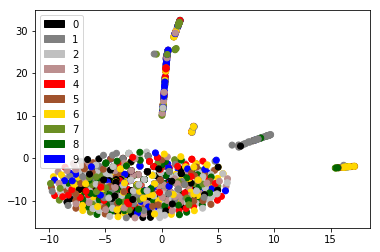

In [ ]:
resnet_4_features_viz = resnet_classifier_4.get_features(x_viz)
visualize_features(resnet_4_features_viz, y_viz, 'resnet50_4')

## TSNE on unfrozen 50 layer residual network features
It appears that we generate better separation between classes with the unfrozen residual network. I suspect that this is the case because the MNIST dataset did not impose a data constraint on us. However, if we were to significantly reduce access to data I suspect that the frozen residual network would provide better features.

In [ ]:
resnet_0_features_viz = resnet_classifier_0.get_features(x_viz)
visualize_features(resnet_0_features_viz, y_viz, 'resnet50_0')

## TSNE on Deep Hybrid Network
Class separation is much stronger here than we experienced in our 50 layer residual network. I am guessing this is because the Deep Hybrid Network allowed for all the weights to be trained. While we froze all the weights and biases below the 3rd block of the resnet.

In [ ]:
scatternet_features_viz = scatternet_classifier.get_features(x_viz)
visualize_features(scatternet_features_viz, y_viz, 'scatternet')

# IMAGE CLASSIFICATION COMPARISON
## Multilayer Neural Network vs. Logistic Regression
The score function we use for comparison is just the mean number of labels correctly assigned to the test samples. The _viz features and labels used below were never used for training. The _viz features and labels were only used for TSNE visualizations and that is why we can still justify using them as our test set.

In [ ]:
def logistic_regression(train_features, train_labels, test_features, test_labels):
    lm = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
    lm.fit(train_features, train_labels)
    score = lm.score(test_features, test_labels)
    return score

def NN_score(nn, x_test, test_labels):
    '''
    nn here either represents the resnet or hybrid scatter network. Here we call them to generate a mean accuracy
    
    we don't submit the same test features here because the network is deterministic and will generate the same
    intermediate features during the forward pass
    '''
    return nn.score(x_test, test_labels)
    

## train images and feature generation

In [ ]:
x_train, y_train = mnist.train.next_batch(1280)
scatternet_features_train = scatternet_classifier.get_features(x_train)
resnet_4_features_train = resnet_classifier_4.get_features(x_train)
resnet_0_features_train = resnet_classifier_0.get_features(x_train)

## Deep Hybrid Scatter Network: logistic regression vs fully connected neural network

In [ ]:
lm_scatternet_score = logistic_regression(scatternet_features_train, y_train, scatternet_features_viz, y_viz)
print('logistic regression on deep hybrid scatter network features accuracy: ', lm_scatternet_score)

nn_scatternet_score = NN_score(scatternet_classifier, x_viz, y_viz)
print('fully connected neural network stacked on scatter network features accuracy: ', nn_scatternet_score)

## Frozen block 4 resnet: logistic regression vs fully connected neural network

In [ ]:
tf.reset_default_graph(); resnet_classifier_4.load() # have to save and load b/c of conflicting params between resnets

lm_res_4_score = logistic_regression(resnet_4_features_train, y_train, resnet_4_features_viz, y_viz)
print('logistic regression on frozen resnet features accuracy: ', lm_res_4_score)

nn_res_4_score = NN_score(resnet_classifier_4, x_viz, y_viz)
print('fully connected neural network stacked on frozen resnet features accuracy: ', nn_res_4_score)

## Unfrozen resnet: logistic regression vs fully connected neural network

In [ ]:
tf.reset_default_graph(); resnet_classifier_0.load() # have to save and load b/c of conflicting params between resnets

lm_res_0_score = logistic_regression(resnet_0_features_train, y_train, resnet_0_features_viz, y_viz)
print('logistic regression on unfrozen resnet features accuracy: ', lm_res_0_score)

nn_res_0_score = NN_score(resnet_classifier_0, x_viz, y_viz)
print('fully connected neural network stacked on unfrozen resnet features accuracy: ', nn_res_0_score)